## **Logistic Regression - Exercise 2: Twitter Sentiment Analysis**
*Ngày 26 tháng 10 năm 2024*

### **1. Initial Setup**

#### *1.1 Import Required Libraries*

In [201]:
# Data manipulation libraries
import pandas as pd
import numpy as np

# Visualization library
import matplotlib.pyplot as plt

# Machine learning tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Additional libraries for text processing
import re
import nltk
from nltk.tokenize import TweetTokenizer
from collections import defaultdict

#### *1.2. Load Dataset*

In [202]:
# Read the Twitter dataset
dataset_path = 'sentiment_analysis.csv'
df = pd.read_csv(
    dataset_path,
    index_col='id'
)
# Display first few rows and basic information
print("First few rows of the dataset:")
df.head()

First few rows of the dataset:


,label,tweet
id,,
1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
2,0,Finally a transparant silicon case ^^ Thanks t...
3,0,We love this! Would you go? #talk #makememorie...
4,0,I'm wired I know I'm George I was made that wa...
5,1,What amazing service! Apple won't even talk to...


In [203]:
print("Dataset information:")
df.info()

Dataset information:
<class 'pandas.core.frame.DataFrame'>
Index: 7920 entries, 1 to 7920
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   7920 non-null   int64 
 1   tweet   7920 non-null   object
dtypes: int64(1), object(1)
memory usage: 185.6+ KB


#### *1.3. Text preprocessing functions*

In [204]:
def text_normalize(text):
    """
        Normalize text by:
        - Removing RT (retweet) mentions
        - Removing hyperlinks
        - Removing hashtags
        - Removing punctuation
        - Tokenizing text
    """
    # Remove retweet old acronym "RT"
    text = re.sub(r'^RT[\s]+', '', text)
    
    # Remove hyperlinks
    text = re.sub(r'https?://.*[\r\n]*', '', text)
    
    # Remove hashtags
    text = re.sub(r'#', '', text)
    
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Tokenization
    tokenizer = TweetTokenizer(
        preserve_case=False,
        strip_handles=True,
        reduce_len=True
    )
    text_tokens = tokenizer.tokenize(text)
    
    return text_tokens

In [205]:
def get_freqs(df):
    """
        Create dictionary storing word frequencies for each class
    """
    freqs = defaultdict(lambda: 0)
    for _, row in df.iterrows():
        tweet = row['tweet']
        label = row['label']
        
        tokens = text_normalize(tweet)
        for token in tokens:
            pair = (token, label)
            freqs[pair] += 1
    
    return freqs

In [206]:
def get_feature(text, freqs):
    """
        Create feature vector for a single tweet
    """
    tokens = text_normalize(text)
    
    X = np.zeros(3)
    X[0] = 1  # bias term
    
    for token in tokens:
        X[1] += freqs[(token, 0)]  # negative frequency
        X[2] += freqs[(token, 1)]  # positive frequency
    
    return X

#### *1.4. Extract Features and Target*

In [207]:
X = []
y = []

# Build frequency dictionary
freqs = get_freqs(df)

# Create feature vectors
for idx, row in df.iterrows():
    tweet = row['tweet']
    label = row['label']
    
    X_i = get_feature(tweet, freqs)
    X.append(X_i)
    y.append(label)

X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (7920, 3)
y shape: (7920,)


### **2. Data Preparation**

#### *2.1. Split Data into Train, Validation, and Test Sets*

In [208]:
# Set splitting parameters
val_size = 0.2    # 20% for validation
test_size = 0.125 # 12.5% for testing
random_state = 2  # For reproducibility
is_shuffle = True # Shuffle data before splitting

# First split: separate validation set
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=val_size,
    random_state=random_state,
    shuffle=is_shuffle
)

# Second split: separate test set from training set
X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=random_state,
    shuffle=is_shuffle
)

# Print shapes of resulting datasets
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Training set shape: (5544, 3)
Validation set shape: (1584, 3)
Test set shape: (792, 3)


#### *2.2. Normalize Features*

In [209]:
# Initialize the scaler
normalizer = StandardScaler()

# Fit and transform training data (excluding bias term)
X_train[:, 1:] = normalizer.fit_transform(X_train[:, 1:])

# Transform validation and test data using training set parameters
X_val[:, 1:] = normalizer.transform(X_val[:, 1:])
X_test[:, 1:] = normalizer.transform(X_test[:, 1:])

print("Feature statistics after normalization:")
print("Mean of training features:", np.mean(X_train[:, 1:], axis=0))
print("Std of training features:", np.std(X_train[:, 1:], axis=0))

Feature statistics after normalization:
Mean of training features: [ 7.65280896e-17 -8.56898327e-17]
Std of training features: [1. 1.]


### **3. Model Functions**

#### *3.1. Sigmoid Function*

In [210]:
def sigmoid(z):
    """
    Compute the sigmoid function.
    
    Args:
        z (np.array): Input values
        
    Returns:
        np.array: Sigmoid of input values
    """
    return 1 / (1 + np.exp(-z))

#### *3.2. Prediction Function*

In [211]:
def predict(X, theta):
    """
    Make predictions using logistic regression.
    
    Args:
        X (np.array): Input features
        theta (np.array): Model parameters
        
    Returns:
        np.array: Predicted probabilities
    """
    dot_product = np.dot(X, theta)
    y_hat = sigmoid(dot_product)
    return y_hat

#### *3.3. Loss Function*

In [212]:
def compute_loss(y_hat, y):
    """
    Compute binary cross-entropy loss.
    
    Args:
        y_hat (np.array): Predicted probabilities
        y (np.array): True labels
        
    Returns:
        float: Average loss value
    """
    # Clip predictions to avoid log(0)
    y_hat = np.clip(y_hat, 1e-7, 1 - 1e-7)
    return (-y * np.log(y_hat) - (1 - y) * np.log(1 - y_hat)).mean()

#### *3.4. Gradient Computation*

In [213]:
def compute_gradient(X, y, y_hat):
    """
    Compute gradient for logistic regression.
    
    Args:
        X (np.array): Input features
        y (np.array): True labels
        y_hat (np.array): Predicted probabilities
        
    Returns:
        np.array: Gradient values
    """
    return np.dot(X.T, (y_hat - y)) / y.size

#### *3.5. Parameter Update Function*

In [214]:
def update_theta(theta, gradient, lr):
    """
    Update model parameters using gradient descent.
    
    Args:
        theta (np.array): Current parameters
        gradient (np.array): Computed gradient
        lr (float): Learning rate
        
    Returns:
        np.array: Updated parameters
    """
    return theta - lr * gradient

#### *3.6. Accuracy Computation*

In [215]:
def compute_accuracy(X, y, theta):
    """
    Compute prediction accuracy.
    
    Args:
        X (np.array): Input features
        y (np.array): True labels
        theta (np.array): Model parameters
        
    Returns:
        float: Accuracy score
    """
    y_hat = predict(X, theta).round()
    acc = (y_hat == y).mean()
    return acc

### **4. Model Training**

#### *4.1. Set Training Parameters*

In [216]:
# Define hyperparameters
lr = 0.01         # Learning rate
epochs = 200      # Number of training epochs
batch_size = 128  # Mini-batch size

# Initialize model parameters
np.random.seed(random_state)
theta = np.random.uniform(size=X_train.shape[1])

# Initialize lists to store metrics
train_accs = []
train_losses = []
val_accs = []
val_losses = []

#### *4.2. Training Loop*

In [217]:
# Main training loop
for epoch in range(epochs):
    # Initialize batch metrics
    train_batch_losses = []
    train_batch_accs = []
    val_batch_losses = []
    val_batch_accs = []
    
    # Mini-batch training
    for i in range(0, X_train.shape[0], batch_size):
        # Get current batch
        X_i = X_train[i:i + batch_size]
        y_i = y_train[i:i + batch_size]
        
        # Forward pass
        y_hat = predict(X_i, theta)
        
        # Compute training loss
        train_loss = compute_loss(y_hat, y_i)
        
        # Compute gradient and update parameters
        gradient = compute_gradient(X_i, y_i, y_hat)
        theta = update_theta(theta, gradient, lr)
        
        # Store batch metrics
        train_batch_losses.append(train_loss)
        
        # Compute accuracies
        train_acc = compute_accuracy(X_train, y_train, theta)
        train_batch_accs.append(train_acc)
        
        # Compute validation metrics
        y_val_hat = predict(X_val, theta)
        val_loss = compute_loss(y_val_hat, y_val)
        val_batch_losses.append(val_loss)
        
        val_acc = compute_accuracy(X_val, y_val, theta)
        val_batch_accs.append(val_acc)
    
    # Compute epoch metrics
    train_batch_loss = sum(train_batch_losses) / len(train_batch_losses)
    val_batch_loss = sum(val_batch_losses) / len(val_batch_losses)
    train_batch_acc = sum(train_batch_accs) / len(train_batch_accs)
    val_batch_acc = sum(val_batch_accs) / len(val_batch_accs)
    
    # Store epoch metrics
    train_losses.append(train_batch_loss)
    val_losses.append(val_batch_loss)
    train_accs.append(train_batch_acc)
    val_accs.append(val_batch_acc)
    
    # Print progress
    if (epoch + 1) % 1 == 0:  # Print every 10 epochs
        print(f'EPOCH {epoch + 1}:')
        print(f'Training Loss: {train_batch_loss:.3f}\tValidation Loss: {val_batch_loss:.3f}')
        print(f'Training Acc: {train_batch_acc:.3f}\tValidation Acc: {val_batch_acc:.3f}\n')

EPOCH 1:
Training Loss: 0.707	Validation Loss: 0.704
Training Acc: 0.556	Validation Acc: 0.547

EPOCH 2:
Training Loss: 0.661	Validation Loss: 0.659
Training Acc: 0.631	Validation Acc: 0.636

EPOCH 3:
Training Loss: 0.624	Validation Loss: 0.622
Training Acc: 0.692	Validation Acc: 0.700

EPOCH 4:
Training Loss: 0.594	Validation Loss: 0.591
Training Acc: 0.733	Validation Acc: 0.744

EPOCH 5:
Training Loss: 0.569	Validation Loss: 0.566
Training Acc: 0.761	Validation Acc: 0.772

EPOCH 6:
Training Loss: 0.548	Validation Loss: 0.546
Training Acc: 0.775	Validation Acc: 0.784

EPOCH 7:
Training Loss: 0.531	Validation Loss: 0.528
Training Acc: 0.785	Validation Acc: 0.790

EPOCH 8:
Training Loss: 0.516	Validation Loss: 0.514
Training Acc: 0.793	Validation Acc: 0.796

EPOCH 9:
Training Loss: 0.504	Validation Loss: 0.502
Training Acc: 0.797	Validation Acc: 0.799

EPOCH 10:
Training Loss: 0.494	Validation Loss: 0.491
Training Acc: 0.802	Validation Acc: 0.797

EPOCH 11:
Training Loss: 0.485	Validati

### **5. Results Analysis**

#### *5.1. Visualize Training Results*

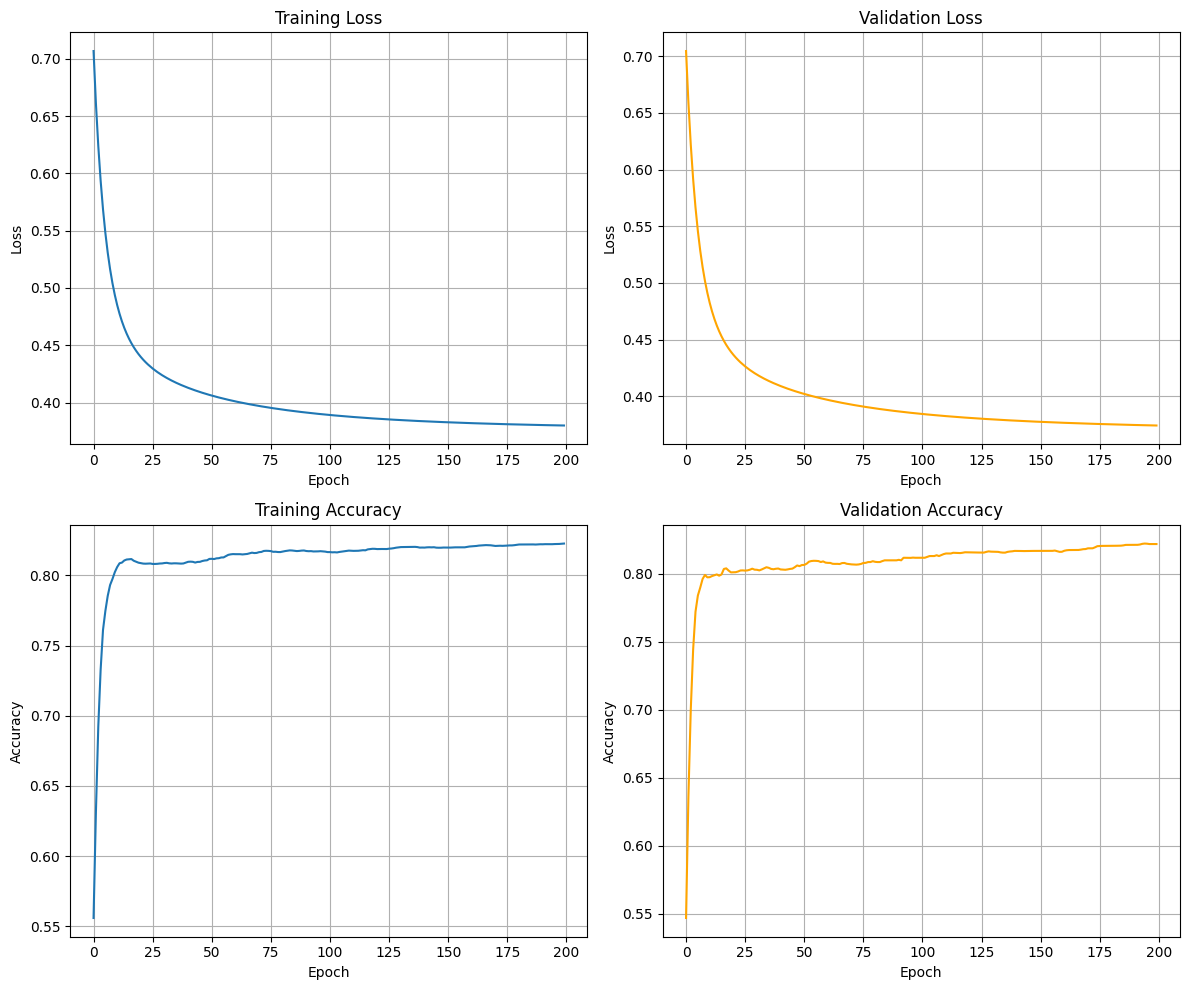

In [218]:
# Create subplots
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Plot training loss
ax[0, 0].plot(train_losses)
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')
ax[0, 0].grid(True)

# Plot validation loss
ax[0, 1].plot(val_losses, 'orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')
ax[0, 1].grid(True)

# Plot training accuracy
ax[1, 0].plot(train_accs)
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')
ax[1, 0].grid(True)

# Plot validation accuracy
ax[1, 1].plot(val_accs, 'orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')
ax[1, 1].grid(True)

plt.tight_layout()
plt.show()

#### *5.2. Model Evaluation*

In [219]:
# Compute final metrics
val_set_acc = compute_accuracy(X_val, y_val, theta)
test_set_acc = compute_accuracy(X_test, y_test, theta)

# Print final results
print("Final Model Evaluation:")
print(f"Validation Accuracy: {val_set_acc:.3f}")
print(f"Test Accuracy: {test_set_acc:.3f}")

# Make predictions on test set
test_predictions = predict(X_test, theta)
print("\nFirst 10 sample predictions from test set:")
for i in range(10):
    print(f"True: {y_test[i]}, Predicted: {test_predictions[i]:.3f}")

Final Model Evaluation:
Validation Accuracy: 0.822
Test Accuracy: 0.843

First 10 sample predictions from test set:
True: 0, Predicted: 0.278
True: 0, Predicted: 0.213
True: 1, Predicted: 0.123
True: 0, Predicted: 0.051
True: 0, Predicted: 0.016
True: 0, Predicted: 0.054
True: 0, Predicted: 0.085
True: 0, Predicted: 0.042
True: 0, Predicted: 0.129
True: 0, Predicted: 0.102
